In [1]:
from collections.abc import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import Colormap
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import (
    ElasticNet,
    Lasso,
    LassoLars,
    LinearRegression,
    PoissonRegressor,
    SGDClassifier,
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeRegressor

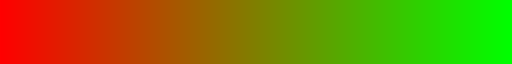

In [2]:
class Gradient(Colormap):
    _isinit = True

    def __init__(self, col1=(0, 1, 0), col2=(1, 0, 0), n_colors=6):
        if len(col1) == 3:
            col1 = [*col1, 1.0]
        if len(col2) == 3:
            col2 = [*col2, 1.0]
        self.n_colors = n_colors
        self.col1 = np.array(col1)
        self.col2 = np.array(col2)
        super().__init__("mymap")

    def __call__(self, num, bytes=False, endp=True):
        if isinstance(num, Iterable):
            res = np.array([self(n, endp=False) for n in num])
            if bytes and endp:
                return (res * 255).astype("uint8")
            return res
        num = min(num, 1)

        return self.col1 * num + self.col2 * (1 - num)

    def __getitem__(self, ind):
        return self(1 - ind / self.n_colors)


Gradient()


# Оптимизация гиперпараметров

Цель работы
Познакомиться с оптимизацией гиперпараметров


**Содержание работы**

-   Сгенерировать датасет для задачи бинарной классификации с использованием функции make_classification.
-   Построить и оценить качество различных моделей классификации, используя метрики accuracy и F1-score.
-   Построить модель elasticnet на данных прогнозирования продаж.
-   Оптимизировать гиперпараметры данной модели с помощью поиска по сетке.


**Методические указания**

Простой выбор модели


Сгенерируем матрицу признаков и вектор целей для задачи классификации. Для этого воспользуемся библиотечной функцией make_classification, которая генерирует случайное распределение по заданным параметрам. Число генерируемых точек данных зададим равным 1000, количество признаков - 5. Классов у нас будет два.


In [3]:
X, Y = make_classification(
    n_samples=1000, n_classes=2, n_features=5, n_redundant=0, random_state=1
)


Выведем количественные параметры датаета:


In [4]:
X.shape, Y.shape

((1000, 5), (1000,))

В датасете описаны 1000 объектов и у каждого есть 5 признаков.

Разделим данные на обучающую и тестовую части:


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


Выведем количественные параметры тестовой и обучающей выборки:


In [6]:
X_train.shape, y_train.shape

((800, 5), (800,))

In [7]:
X_test.shape, y_test.shape

((200, 5), (200,))

Построение различных моделей классификации


In [8]:
names = [
    "Nearest_Neighbors",
    "Linear_SVM",
    "Polynomial_SVM",
    "RBF_SVM",
    "Gaussian_Process",
    "Gradient_Boosting",
    "Decision_Tree",
    "Extra_Trees",
    "Random_Forest",
    "Neural_Net",
    "AdaBoost",
    "Naive_Bayes",
    "QDA",
    "SGD",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="l2"),
]


Необходимо сравнить модели друг с другом и выбрать наиболее точные. Обучим модель, примените модель к тестовым данным и запишите показатели точности.


In [9]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)


c:\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Анализ производительности модели

Сформируем DataFrame для наглядного отображения показателя точности


In [10]:
df = pd.DataFrame()
df["name"] = names
df["score"] = scores
df.sort_values(by=["score"], ascending=False, inplace=True)
df


,name,score
6,Decision_Tree,0.860
9,Neural_Net,0.840
4,Gaussian_Process,0.835
8,Random_Forest,0.830
7,Extra_Trees,0.825
11,Naive_Bayes,0.825
1,Linear_SVM,0.820
5,Gradient_Boosting,0.820
0,Nearest_Neighbors,0.815
3,RBF_SVM,0.815


In [11]:
# cm = sns.light_palette("green", as_cmap=True)
cm = Gradient(n_colors=len(df))

s = df.style.background_gradient(cmap=cm)
s


,name,score
6,Decision_Tree,0.860000
9,Neural_Net,0.840000
4,Gaussian_Process,0.835000
8,Random_Forest,0.830000
7,Extra_Trees,0.825000
11,Naive_Bayes,0.825000
1,Linear_SVM,0.820000
5,Gradient_Boosting,0.820000
0,Nearest_Neighbors,0.815000
3,RBF_SVM,0.815000


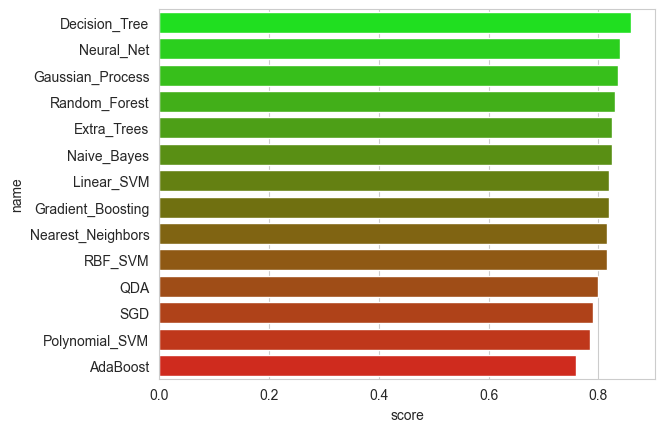

In [12]:
sns.set_style("whitegrid")

ax = sns.barplot(
    y="name",
    x="score",
    hue="name",
    legend=False,
    data=df,
    palette=cm,
)


Рассмотрим как мы можем оптимизировать методы. Для этого выберем метод Grid Search. И раасмотрим пример на основе данных затрат на рекламу.


Рассмотрим реализацию для оптимизации производительности метода машинного обучения с помощью Grid Search.


Настройка гиперпараметров важна для правильной работы моделей машинного обучения (ML). Grid Search, является базовым методом для оптимизации гиперпараметров. Данный метод рассматривает некоторые комбинации гиперпараметров и выбирает ту, которая дает более низкий балл ошибки.


Поиск по сетке
Мы можем перебирать комбинации гиперпараметров с помощью поиска по сетке (grid). Линейные модели достаточно просты, и у них даже есть свои специализированные версии поиска значений параметров. Но также можно использовать обобщённый метод поиска по сетке - grid search. Этот метод применим для любой модели в sklearn, и он пригодится нам позже для более сложных моделей.


Мы будем использовать данные из книги ISLR (Introduction to Statistical Learning: With Applications in R). Это будут продажи определённого продукта (в тысячах единиц), как функция от бюджета рекламы на ТВ, радио и в газетах (в тысячах долларов). Наша задача исследовать на сколько реклама влияет на продажу товаров. Если мы выясним что никакой связи нет, то тогда не стоит тратить деньги на рекламу. Мы хотели бы увидеть чем больше тратится денег на рекламу тем больше продаются товары.


In [13]:
# df = pd.read_csv("Advertising.csv")
df = pd.read_csv(
    "https://raw.githubusercontent.com/koroteevmv/ML_course/main/ML4.5%20hyperparameters/Advertising.csv"
)


Посмотрим на данные, видим кол-во денег, потраченное на рекламу, отдельно на TV, radio, newspaper, за некоторый период времени, например за неделю. Sales объем продаж товаров, за тот же самый период времени.


In [14]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Далее разобьем данные на признаки и целевую переменную. Признаки это все колонки кроме целевой переменной, один из способов быстро получить все эти колонки df.drop('sales',axis=1). Все признаки измеряются в одних и тех же единицах измерения.


Библиотека Python sklearn предлагает нам функцию StandardScaler() для стандартизации значений данных в стандартный формат. В соответствии с приведенным ниже синтаксисом мы изначально создаем объект функции StandardScaler(). Далее используем fit_transform() вместе с присвоенным объектом для преобразования данных и их стандартизации.


In [15]:
## Создаём X и y
X = df.drop("sales", axis=1)
y = df["sales"]

# Разбиение на обучающий и тестовый наборы - TRAIN TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101
)

# Масштабирование данных (SCALE)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


ElasticNet это популярный тип регуляризованной линейной регрессии, который сочетает в себе два популярных штрафа, а именно штрафные функции L1 и L2.


В модели ElasticNet есть два парамера L1_ratio он задает соотношение между Lasso регрессией и Ridg регрессией, второй параметр alfa - отвечает за то на сколько сильно мы применяем штрафное слагаемое для регуляризации. Задача состоит в том что бы найти такие параметры alfa и L1_ratio которые будут оптимальными.


Значения гиперпараметров будем искать используя готовый класс Grid SearchCV.

Этот поиск состоит из следующих составляющих:

функция оценки - estimator (рregressor или classifier, например sklearn.svm.SVC());
пространство параметров;
метод поиска или сэмплирования кандидатов;
схема кросс-валидации
функция оценки (score function).
Cоздадим экземпляр модели ElasticNet() со значениями по умолчанию.


In [16]:
base_elastic_model = ElasticNet()

Создаем переменную param_grid это будет словарь в котором укажем возможные значения гиперпараметров которые хотим исследовать


In [17]:
param_grid = {
    "alpha": [0.1, 1, 5, 10, 50, 100],
    "l1_ratio": [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
}


Мы создали сетку с возможными значениями гиперпараметров.

Далее выполним поиск по сетке, для этого импортируем GridSearchCV


Укажем параметры для GridSearchCV.

Существуют следующие параметры:
- estimator
- param_grid
- scoring=None
- n_jobs=None
- refit=True
- cv=None
- verbose=0
- pre_dispatch='2n_jobs'
- error_score=nan
- return_train_score=False


In [18]:
# число verbose выбирайте сами
grid_model = GridSearchCV(
    estimator=base_elastic_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
)


In [19]:
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ............................alpha=0.1, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=0.1, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.1,

[CV] END ............................alpha=10, l1_ratio=0.95; total time=   0.2s
[CV] END ............................alpha=10, l1_ratio=0.95; total time=   0.0s
[CV] END ............................alpha=10, l1_ratio=0.99; total time=   0.0s
[CV] END ............................alpha=10, l1_ratio=0.99; total time=   0.0s
[CV] END ............................alpha=10, l1_ratio=0.99; total time=   0.0s
[CV] END ............................alpha=10, l1_ratio=0.99; total time=   0.0s
[CV] END ............................alpha=10, l1_ratio=0.99; total time=   0.0s
[CV] END ...............................alpha=10, l1_ratio=1; total time=   0.0s
[CV] END ...............................alpha=10, l1_ratio=1; total time=   0.6s
[CV] END ...............................alpha=10, l1_ratio=1; total time=   0.0s
[CV] END ...............................alpha=10, l1_ratio=1; total time=   0.0s
[CV] END ...............................alpha=10, l1_ratio=1; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=2)

Посмотреть какая модель получилась наилучшая:


In [20]:
grid_model.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=1)

Видим ElasticNet с параметрами. Это наилучшая комбинация гиперпараметров

Если параметры нас устраивают переходим к созданию модели


In [21]:
y_pred = grid_model.predict(X_test)

И вычисляем метрики


In [22]:
mean_squared_error(y_test, y_pred)

2.387342642087474

## Контрольные вопросы
1. Зачем нужно производить оптимизацию гиперпараметров?
2. В чём заключается процесс оптимизации гиперпараметров?
3. В чем достоинства и недостатки метода gridsearchcv?
4. Какие еще стратегии оптимизации гиперпараметров существуют?
5. Почему при использовании GridSearchCV не нужна валидационная выборка?


---
## Дополнительные задания

1. При выборе модели мы обычно выбираем ту, которая дает наибольшее значение какой-то метрики. Но это означает, что эта оценка метрики уже становится завышенной. Поэтому для объективной оценки качества модели ее опять следует оценить на новом наборе данных. Поэтому для выбора модели нужно разделить выборку на три части - обучающую, валидационную и тестовую. Повторите первую часть работы, но с таким разбиением и получите несмещенную оценку качества наилучшей модели.

In [23]:
X, Y = make_classification(
    n_samples=1000, n_classes=2, n_features=5, n_redundant=0, random_state=1
)

In [24]:
# Деление на тестовую и обучающую выбори
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

# Деление на обучающую и валидационную выборки
X_test, X_validate, y_test, y_validate = train_test_split(
    X_test, y_test, test_size=0.8, stratify=y_test
)


In [25]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)


c:\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


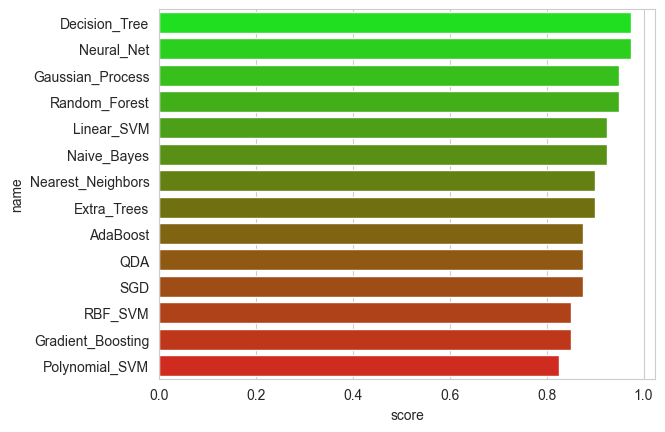

In [26]:
df = pd.DataFrame()
df["name"] = names
df["score"] = scores
df.sort_values(by=["score"], ascending=False, inplace=True)
sns.set_style("whitegrid")

ax = sns.barplot(
    y="name",
    x="score",
    hue="name",
    legend=False,
    data=df,
    palette=cm,    
)


In [27]:
print(f"Лучшая модель: {df['name'].iloc[0]}")
print(f"Точность: {df['score'].iloc[0]}")

Лучшая модель: Decision_Tree
Точность: 0.975


Оценим на валидационном датасете

In [28]:
clf = dict(zip(names, classifiers))[df["name"].iloc[0]]
clf.fit(X_train, y_train)
score = clf.score(X_validate, y_validate)

# Несмещенная оценка качества наилучшей модели.
print(f"Точность на валидационном датасете: {score}")


Точность на валидационном датасете: 0.85


---
2. Оптимизируйте гиперпараметры той же модели, но другим методом - случайным поиском. Сравните полученные результаты.

In [29]:
from scipy.stats import uniform

In [30]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/koroteevmv/ML_course/main/ML4.5%20hyperparameters/Advertising.csv"
)

## Создаём X и y
X = df.drop("sales", axis=1)
y = df["sales"]

# Разбиение на обучающий и тестовый наборы - TRAIN TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101
)

# Масштабирование данных (SCALE)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [31]:
alpha_min, alpha_max = 0.1, 10
alpha_distribution = uniform(loc=alpha_min, scale=alpha_max - alpha_min)

param_dist = {
    "alpha": alpha_distribution,
    "l1_ratio": uniform(0, 1),
}


In [32]:
base_elastic_model = ElasticNet()
grid_model = RandomizedSearchCV(
    param_distributions=param_dist,
    estimator=base_elastic_model,
    scoring="neg_mean_squared_error",
    n_iter=1000
)


In [33]:
grid_model.fit(X_train, y_train)

RandomizedSearchCV(estimator=ElasticNet(), n_iter=1000,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C0F4AA03E0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C0F4A80F50>},
                   scoring='neg_mean_squared_error')

In [34]:
grid_model.best_estimator_

ElasticNet(alpha=0.11517681879886901, l1_ratio=0.7212289649051735)

In [35]:
# Вычисляем метрики модели
y_pred = grid_model.predict(X_test)
mean_squared_error(y_test, y_pred)


2.498654624569191

При рандомном поиски с использованим равномерного распределения получается чуть менее точная модель

---
3. Во второй задаче найдите наиболее эффективный класс моделей, а затем оптимизируйте гиперпараметры у этой модели. Сравните, насколько лучше получилась модель.


In [38]:
regressors = [
    ElasticNet,
    LinearRegression,
    ExtraTreeRegressor,
    KNeighborsRegressor,
    Lasso,
    PoissonRegressor,
    LassoLars,
]

regressors = {reg.__name__: reg for reg in regressors}


In [40]:
scores = []
for name, reg in regressors.items():
    model = reg().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    scores.append(score)


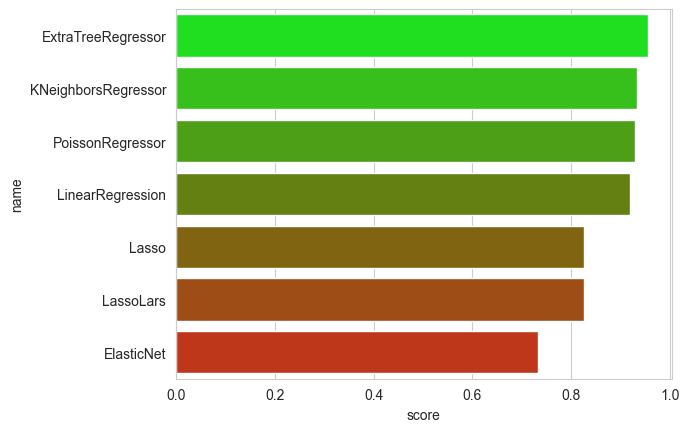

In [41]:
df = pd.DataFrame()
df["name"] = regressors.keys()
df["score"] = scores
df.sort_values(by=["score"], ascending=False, inplace=True)
sns.set_style("whitegrid")

cm = Gradient(n_colors=len(df))
ax = sns.barplot(
    y="name",
    x="score",
    hue="name",
    legend=False,
    data=df,
    palette=cm,
)


In [42]:
print(f"Лучшая модель: {df['name'].iloc[0]}")
print(f"Точность: {df['score'].iloc[0]}")

Лучшая модель: ExtraTreeRegressor
Точность: 0.9558777473958731


Делаем поиск по сетке меняя максимальную глубину

In [53]:
param_grid = {
    "max_depth": range(1, 30),
}

In [52]:
extratree_model = ExtraTreeRegressor()

In [56]:
grid_model = GridSearchCV(
    estimator=extratree_model,
    param_grid=param_grid,
    scoring="r2",
    cv=3,
    verbose=1,
)


In [57]:
grid_model.fit(X_train, y_train)

Fitting 3 folds for each of 29 candidates, totalling 87 fits


GridSearchCV(cv=3, estimator=ExtraTreeRegressor(),
             param_grid={'max_depth': range(1, 30)}, scoring='r2', verbose=1)

In [58]:
grid_model.best_estimator_

ExtraTreeRegressor(max_depth=23)

Лучшая максимальная глубин: 23

In [59]:

y_pred = grid_model.predict(X_test)
score = r2_score(y_test, y_pred)
score


0.9686173541820258

Точность выросла

In [60]:
print(f"Прирост точности: {score - df['score'].iloc[0]:.3%}")


Прирост точности: 1.274%
